In [9]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 
sys.path.append(config.script_dir)
from slide_registration import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 457 µs


In [15]:
class args:
    def __init__(self):
        args.input = ['/mnt/z/Marilyne/Axioscan/6-Dhivya/split/No_Scene/']
        args.output = ['/mnt/e/CycIF_analysis/registration_outputs/test/']
        args.slide = ['D1']
        args.scene = ['None']
args = args()

In [16]:
print('input directory:', args.input[0])
print('output directory:', args.output[0])
print('slide name:', args.slide[0])
print('scene name:', args.scene[0])
print()

input directory: /mnt/z/Marilyne/Axioscan/6-Dhivya/split/No_Scene/
output directory: /mnt/e/CycIF_analysis/registration_outputs/test/
slide name: D1
scene name: None



In [10]:
img_file_names = [x for x in os.listdir(args.input[0]) if x[-4:] == '.tif']
parsed_names = pd.DataFrame([parse_file_name(x) for x in img_file_names])

# filter to slide/scene
parsed_names = parsed_names[lambda x: (x.slide_name == args.slide[0]) & (x.scene == args.scene[0])]

# FOR TESTING
parsed_names = parsed_names[lambda x: x['round'].isin(['R0','R1'])]

In [11]:
# load fixed image 
print('loading fixed image')
fixed_path = args.input[0] + '/' + parsed_names[lambda x: (x['round'] == 'R0') & (x['color_channel'] == 'c1')].original.item()
fixed = sitk.ReadImage(fixed_path, sitk.sitkUInt16)

# for aesthetics 
parsed_names = parsed_names.sort_values('round')

loading fixed image


In [32]:
# load images
imgs = {} 
for i, row in parsed_names[lambda x: (x['round'] == 'R1') & (x['color_channel'] == 'c1')].iterrows(): 
    print(i)
    imgs[row.color_channel] = sitk.ReadImage(args.input[0] + '/' + row.original , sitk.sitkUInt16)

165


In [36]:
# check the spacing 
for _im in imgs:
    print(imgs[_im].GetSpacing())
    
fixed.GetSpacing()

(1.0, 1.0)


(1.0, 1.0)

In [34]:
# check origin
for _im in imgs:
    print(imgs[_im].GetOrigin())
    
fixed.GetOrigin()

(0.0, 0.0)


(0.0, 0.0)

In [35]:
# try resetting spacing for proper translation
for _im in imgs:
    imgs[_im].SetSpacing((1,1))
    
fixed.SetSpacing((1,1))

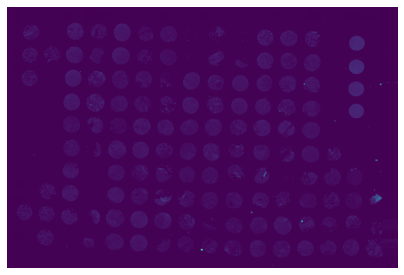

In [37]:
utils.myshow(imgs['c1'][::10, ::10])

In [38]:
x,y = get_round_registration(fixed, imgs['c1'])

In [39]:
print(x,y)

0 221


In [56]:
reg_imgs = transform_all_channels(fixed, imgs, x, y)

R1_H3K27ME3.AXL.CCND1.HER2_D1_2020_10_02__9177_c1_ORG.tif
16-bit unsigned integer


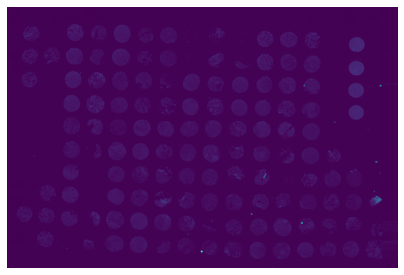

In [71]:
name = moving_df[lambda x: x['color_channel'] == 'c1'].original.item()
print(name)
print(reg_imgs['c1'].GetPixelIDTypeAsString())
utils.myshow(reg_imgs['c1'][::10, ::10])
img = reg_imgs['c1']
name = args.output[0] + '/' + name
sitk.WriteImage(img, name)

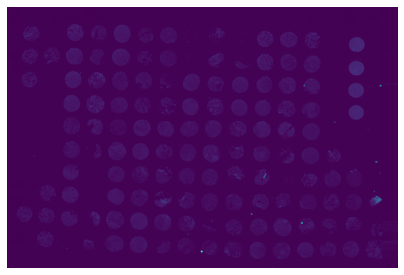

In [72]:
img2 = sitk.ReadImage(name, sitk.sitkUInt16)
utils.myshow(img2[::10, ::10])

In [54]:
# check origin
print( reg_imgs['c1'].GetOrigin())
fixed.GetOrigin()

(0.0, 0.0)


(0.0, 0.0)

In [55]:
print(reg_imgs['c1'].GetSize())
fixed.GetSize()

(38822, 25951)


(38822, 25951)

In [42]:
def plot_subtraction(fixed, moving, ds=10):
    
    fixed.SetSpacing((1,1))
    moving.SetSpacing((1,1))
    
    img1_ds = fixed[::ds, ::ds]
    img2_ds = moving[::ds, ::ds]
    
    #img1_ds = segment.perform_otsu_threshold(img1_ds)
    #img2_ds = segment.perform_otsu_threshold(img2_ds)
    
    utils.myshow(img1_ds)
    utils.myshow(img2_ds)
    
    # cast as float to avoid int overflow 
    img1_ds = sitk.Cast(img1_ds, sitk.sitkFloat32)
    img2_ds = sitk.Cast(img2_ds, sitk.sitkFloat32)

    # take differnce
    sub = img1_ds - img2_ds

    # plot difference
    utils.myshow(sub, figsize=(7,7))

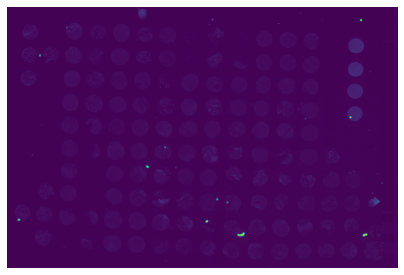

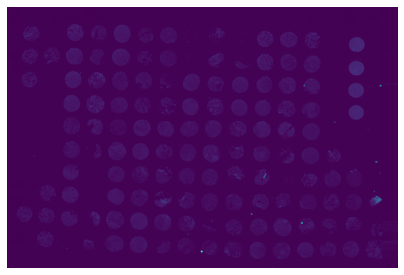

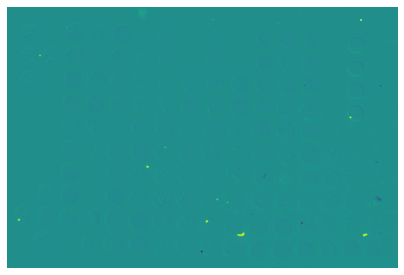

In [53]:


plot_subtraction(fixed, reg_imgs['c1'])